# Intrusion Detection for Unix Processes

In [106]:
# Importing necessary libraries
import os
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

In [54]:
# Define the chunk length
chunk_length = 7

directory_path = 'syscalls/'

# File paths for snd-cert
snd_cert_train_file_path = os.path.join(directory_path, 'snd-cert/train/snd-cert.train')
snd_cert_test_file_paths = [os.path.join(directory_path, f'snd-cert/tests/snd-cert.{i}.test') for i in range(1, 4)]
snd_cert_label_file_paths = [os.path.join(directory_path, f'snd-cert/labels/snd-cert.{i}.labels') for i in range(1, 4)]
snd_cert_alpha_file_path = os.path.join(directory_path, 'snd-cert/alphabet/snd-cert.alpha')

# File paths for snd-unm
snd_unm_train_file_path = os.path.join(directory_path, 'snd-unm/train/snd-unm.train')
snd_unm_test_file_paths = [os.path.join(directory_path, f'snd-unm/tests/snd-unm.{i}.test') for i in range(1, 4)]
snd_unm_label_file_paths = [os.path.join(directory_path, f'snd-unm/labels/snd-unm.{i}.labels') for i in range(1, 4)]
snd_unm_alpha_file_path = os.path.join(directory_path, 'snd-unm/alphabet/snd-unm.alpha')

In [55]:
def preprocess_sequence(sequence,
                        chunk_length,
                        overlap=True):
    """
    Preprocesses a given sequence into fixed-length chunks.
    
    This function splits a sequence into substrings of a specified fixed length. It supports both overlapping
    and non-overlapping chunking methods. Overlapping chunks (substrings) are generated by moving one character
    at a time, while non-overlapping chunks are generated by moving the entire length of the chunk each time.
    
    Parameters:
    - sequence (str): The input sequence to be chunked.
    - chunk_length (int): The length of each chunk (substring) to be generated.
    - overlap (bool): Determines the chunking method. If True, overlapping chunks are created. If False,
                      non-overlapping chunks are generated.
    
    Returns:
    - chunks (list of str): A list of substrings (chunks) of the input sequence. If the input sequence is shorter
                            than the specified chunk length and cannot be chunked, an empty list is returned.
    
    Note:
    - The function strips trailing newlines and spaces from the input sequence before chunking.
    - If 'overlap' is True, each chunk will be shifted by one character from the previous chunk, leading to
      a higher number of generated chunks, each sharing a part with its neighbors.
    - If 'overlap' is False, each chunk starts right after the previous one ends, with no shared characters
      between consecutive chunks, leading to a lower number of generated chunks.
    """

    # Check if the sequence length is at least as long as the chunk length
    if len(sequence) < chunk_length:
        # If the sequence is shorter than the chunk length, return an empty list or handle accordingly
        return []

    # Initialize an empty list to store the chunks
    chunks = []

    # Remove any trailing newline or spaces from the sequence
    # sequence = sequence.strip()
    # Determine the step size based on whether overlapping chunks are desired
    step = 1 if overlap else chunk_length
    # Generate and append chunks to the list
    for i in range(0, len(sequence) - chunk_length + 1, step):
        chunk = sequence[i:i + chunk_length]
        chunks.append(chunk)

    return chunks

In [56]:
# Read and preprocess the .train file first for snd-cert and snd-unm
with open(snd_cert_train_file_path, 'r') as file:
    snd_cert_train_sequences = file.readlines()

with open(snd_unm_train_file_path, 'r') as file:
    snd_unm_train_sequences = file.readlines()

# Define paths for output files
snd_cert_train_chunks_file = os.path.join(directory_path, 'snd-cert/train/snd_cert_train_chunks.train')
snd_unm_train_chunks_file = os.path.join(directory_path, 'snd-unm/train/snd_unm_train_chunks.train')

# Preprocess train sequences for snd-cert and save to file
with open(snd_cert_train_chunks_file, 'w') as output_file:
    snd_cert_train_chunks = []
    for sequence in snd_cert_train_sequences:
        # Call the preprocess function for each sequence
        chunks = preprocess_sequence(sequence, chunk_length, overlap=False)
        snd_cert_train_chunks.extend(chunks)
        # Write each chunk to the file
        for chunk in chunks:
            output_file.write(chunk + '\n')

# Preprocess train sequences for snd-unm and save to a file
with open(snd_unm_train_chunks_file, 'w') as output_file:
    snd_unm_train_chunks = []
    for sequence in snd_unm_train_sequences:
        # Call the preprocess function for each sequence
        chunks = preprocess_sequence(sequence, chunk_length, overlap=False)
        snd_unm_train_chunks.extend(chunks)
        # Write each chunk to the file
        for chunk in chunks:
            output_file.write(chunk + '\n')

# Print the first 5 sequences to check
print("SND-CERT first 5 train chunks:")
for i, chunk in enumerate(snd_cert_train_chunks[:5], start=1):
    print(f"Chunk {i}: {chunk}")

# Print the first 5 sequences to check
print("\n" + "-" * 50 + "\n")
print("SND-UNM first 5 train chunks:")
for i, chunk in enumerate(snd_unm_train_chunks[:5], start=1):
    print(f"Chunk {i}: {chunk}")

SND-CERT first 5 train chunks:
Chunk 1: AEEEEEE
Chunk 2: DBccD=c
Chunk 3: EOVDPcE
Chunk 4: DBccEDB
Chunk 5: ccEEhEE

--------------------------------------------------

SND-UNM first 5 train chunks:
Chunk 1: pooqpoo
Chunk 2: qpooqED
Chunk 3: EESSprs
Chunk 4: NNpooqd
Chunk 5: spooqdN


In [57]:
def save_chunks_with_identifiers(test_file_path,
                                 chunk_length,
                                 overlap=True,
                                 output_chunk_file_path=None,
                                 output_identifier_file_path=None):
    """
    Splits test sequences into fixed-length chunks and assigns identifiers to track which chunks belong to the same original sequence.
    
    Returns:
    - Tuple of (chunks, identifiers) where 'chunks' is a list of the sequence chunks and 'identifiers' is a list of corresponding sequence identifiers.
    """
    # Read test sequences from file
    with open(test_file_path, 'r') as file:
        test_sequences = file.read().splitlines()

    # Initialize lists for chunks and their identifiers
    chunks = []
    identifiers = []

    # Process each sequence to generate chunks and assign an identifier to each chunk
    for sequence_id, sequence in enumerate(test_sequences):
        sequence_chunks = preprocess_sequence(sequence, chunk_length, overlap)
        chunks.extend(sequence_chunks)
        identifiers.extend([sequence_id] * len(sequence_chunks))  # Assign the sequence ID to all of its chunks

    # Save chunks and their identifiers to specified output files
    if output_chunk_file_path and output_identifier_file_path:
        with open(output_chunk_file_path, 'w') as chunk_file, open(output_identifier_file_path, 'w') as id_file:
            for chunk, id in zip(chunks, identifiers):
                chunk_file.write(chunk + '\n')
                id_file.write(str(id) + '\n')

    return chunks, identifiers

In [100]:
# Process and save test sequences with identifiers for both snd-cert and snd-unm datasets.

# Define the output file paths for chunks and their corresponding identifiers.
output_files_snd_cert = [
    (os.path.join(directory_path, f'snd-cert/tests/snd_cert_test_set_{i}_chunks.test'),
     os.path.join(directory_path, f'snd-cert/tests/snd_cert_test_set_{i}_identifiers.txt'))
    for i in range(1, 4)]

output_files_snd_unm = [
    (os.path.join(directory_path, f'snd-unm/tests/snd_unm_test_set_{i}_chunks.test'),
     os.path.join(directory_path, f'snd-unm/tests/snd_unm_test_set_{i}_identifiers.txt'))
    for i in range(1, 4)]

# Iterate over test and label file paths along with output file paths for snd-cert
for (test_file, label_file), (output_chunk_file, output_label_file) in zip(
        zip(snd_cert_test_file_paths, snd_cert_label_file_paths), output_files_snd_cert):
    snd_cert_test_chunks, snd_cert_test_identifier = save_chunks_with_identifiers(test_file,
                                                                                  chunk_length,
                                                                                  overlap=False,
                                                                                  output_chunk_file_path=output_chunk_file,
                                                                                  output_identifier_file_path=output_label_file)

# Iterate over test and label file paths along with output file paths for snd-unm
for (test_file, label_file), (output_chunk_file, output_label_file) in zip(
        zip(snd_unm_test_file_paths, snd_unm_label_file_paths), output_files_snd_unm):
    snd_unm_test_chunks, snd_unm_test_identifier = save_chunks_with_identifiers(test_file,
                                                                                chunk_length,
                                                                                overlap=False,
                                                                                output_chunk_file_path=output_chunk_file,
                                                                                output_identifier_file_path=output_label_file)

# Print the first 5 sequences to check
example_chunk_file = os.path.join(directory_path, 'snd-cert/tests/snd_cert_test_set_1_chunks.test')
example_identifier_file = os.path.join(directory_path, 'snd-cert/tests/snd_cert_test_set_1_identifiers.txt')

print("First 5 chunks and their corresponding identifiers from SND-CERT Test Set 1:")
with open(example_chunk_file, 'r') as chunks_file, open(example_identifier_file, 'r') as ids_file:
    for _ in range(5):
        chunk = chunks_file.readline().strip()
        identifier = ids_file.readline().strip()
        print(f"Chunk: {chunk}, Identifier: {identifier}")

First 5 chunks and their corresponding identifiers from SND-CERT Test Set 1:
Chunk: srrtsuv, Identifier: 0
Chunk: NNsrrtf, Identifier: 0
Chunk: vsrrtfN, Identifier: 0
Chunk: DlmEvNl, Identifier: 0
Chunk: oW-kwEE, Identifier: 0


In [66]:
def get_sequences_score(file_path_scores,
                        file_path_identifier,
                        file_path_label):
    """
    This method calculates the average anomaly score for each sequence by grouping individual chunk scores based on shared identifiers, then returns these average scores along with their corresponding sequence labels.
    """
    # Read anomaly scores from the file
    with open(file_path_scores, 'r') as file:
        scores = [float(line.strip()) for line in file.readlines()]

    # Read identifiers to group scores by originating sequence
    with open(file_path_identifier, 'r') as file:
        identifiers = [int(line.strip()) for line in file.readlines()]
        # print(identifiers)

    # Read labels corresponding to each sequence
    with open(file_path_label, 'r') as file:
        labels = [int(line.strip()) for line in file.readlines()]

    # Initialize a list to hold the average score of each sequence
    sequence_scores = []

    # Initialize a list to accumulate scores for the current sequence
    current_sequence_scores = [scores[0]]

    # Loop through all scores to calculate average scores per sequence
    for i in range(1, len(scores)):
        # If the current score belongs to the same sequence, add it to the accumulator
        if identifiers[i] == identifiers[i - 1]:
            current_sequence_scores.append(scores[i])
        else:
            # If the current score belongs to a new sequence, calculate the average score of the previous sequence
            sequence_scores.append(sum(current_sequence_scores) / len(current_sequence_scores))
            # Reset the accumulator for the new sequence
            current_sequence_scores = [scores[i]]

    # Ensure the average score of the last sequence is also included
    sequence_scores.append(sum(current_sequence_scores) / len(current_sequence_scores))

    current_sequence_scores = [scores[i]]

    # Return the list of average sequence scores and their corresponding labels
    return sequence_scores, labels

Will generate results for r = 2 and r =3. We avoided to use r = 4 as it took too much time for tests sets with larger size such as test 2 and 3.
- **Command structure that includes the alphabet file for the Unix process task for snd-cert**:
    ```bash
    java -jar negsel2.jar -alphabet file://snd-cert.alpha -self snd_cert_train_chunks.train -n 10 -r 3 -c -l < snd_cert_test_set_<test_no>_chunks.test >snd_cert_test_set_<test_no>_chunks_scores_r3.txt
    ```
- **Same for snd-unm**:
    ```bash
    java -jar negsel2.jar  -alphabet file://snd-unm.alpha -self snd_unm_train_chunks.train -n 10 -r 3 -c -l < snd_unm_test_set_<test_no>_chunks.test >snd_unm_test_set_<test_no>_chunks_scores_r4.txt
    ```

In [107]:
def compute_auc(scores, labels):
    # Combine scores with labels and sort them
    scores_with_labels = list(zip(scores, labels))
    scores_with_labels.sort(key=lambda x: x[0])

    # Separate scores and labels after sorting
    sorted_scores = [pair[0] for pair in scores_with_labels]
    sorted_labels = [pair[1] for pair in scores_with_labels]

    # Compute ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(sorted_labels, sorted_scores)
    auc_score = roc_auc_score(sorted_labels, sorted_scores)

    return fpr, tpr, auc_score

In [123]:
def plot_roc_curve(fpr, tpr, roc_auc, r, language):
    """
    Function to plot ROC curve
    """
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title(f'{language} Discrimination from English ROC (n=7, r={r})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [124]:
# Load the scores and labels for the first test set of the snd-cert dataset for r = 2
scores_cert1_r2, labels_cert1_r2 = get_sequences_score(
    "syscalls/snd-cert/scores/snd_cert_test_set_1_chunks_scores_r2.txt",
    "syscalls/snd-cert/tests/snd_cert_test_set_1_identifiers.txt",
    "syscalls/snd-cert/labels/snd-cert.1.labels")

# Load the scores and labels for the first test set of the snd-unm dataset for r = 2 
scores_unm1_r2, labels_unm1_r2 = get_sequences_score("syscalls/snd-unm/scores/snd_unm_test_set_1_chunks_scores_r2.txt",
                                                     "syscalls/snd-unm/tests/snd_unm_test_set_1_identifiers.txt",
                                                     "syscalls/snd-unm/labels/snd-unm.1.labels")

# Load the scores and labels for the second test set of the snd-cert dataset for r = 2
scores_cert2_r2, labels_cert2_r2 = get_sequences_score(
    "syscalls/snd-cert/scores/snd_cert_test_set_2_chunks_scores_r2.txt",
    "syscalls/snd-cert/tests/snd_cert_test_set_2_identifiers.txt",
    "syscalls/snd-cert/labels/snd-cert.2.labels")

# Load the scores and labels for the second test set of the snd-unm dataset for r = 2 
scores_unm2_r2, labels_unm2_r2 = get_sequences_score("syscalls/snd-unm/scores/snd_unm_test_set_2_chunks_scores_r2.txt",
                                                     "syscalls/snd-unm/tests/snd_unm_test_set_2_identifiers.txt",
                                                     "syscalls/snd-unm/labels/snd-unm.2.labels")

# Load the scores and labels for the third test set of the snd-cert dataset for = 2
scores_cert3_r2, labels_cert3_r2 = get_sequences_score(
    "syscalls/snd-cert/scores/snd_cert_test_set_3_chunks_scores_r2.txt",
    "syscalls/snd-cert/tests/snd_cert_test_set_3_identifiers.txt",
    "syscalls/snd-cert/labels/snd-cert.3.labels")

# Load the scores and labels for the third test set of the snd-unm dataset for r = 2 
scores_unm3_r2, labels_unm3_r2 = get_sequences_score("syscalls/snd-unm/scores/snd_unm_test_set_3_chunks_scores_r2.txt",
                                                     "syscalls/snd-unm/tests/snd_unm_test_set_3_identifiers.txt",
                                                     "syscalls/snd-unm/labels/snd-unm.3.labels")

In [125]:
# Calculate AUC for each test set
fpr_cert1_r2, tpr_cert1_r2, auc_cert1_r2 = compute_auc(scores_cert1_r2, labels_cert1_r2)
fpr_unm1_r2, tpr_unm1_r2, auc_unm1_r2 = compute_auc(scores_unm1_r2, labels_unm1_r2)

fpr_cert2_r2, tpr_cert2_r2, auc_cert2_r2 = compute_auc(scores_cert2_r2, labels_cert2_r2)
fpr_unm2_r2, tpr_unm2_r2, auc_unm2_r2 = compute_auc(scores_unm2_r2, labels_unm2_r2)

fpr_cert3_r2, tpr_cert3_r2, auc_cert3_r2 = compute_auc(scores_cert3_r2, labels_cert3_r2)
fpr_unm3_r2, tpr_unm3_r2, auc_unm3_r2 = compute_auc(scores_unm3_r2, labels_unm3_r2)

# Print AUC scores
print(f"AUC for SND-CERT Test Set 1: {auc_cert1_r2}")
print(f"AUC for SND-UNM Test Set 1: {auc_unm1_r2}\n")

print(f"AUC for SND-CERT Test Set 2: {auc_cert2_r2}")
print(f"AUC for SND-UNM Test Set 2: {auc_unm2_r2}\n")

print(f"AUC for SND-CERT Test Set 3: {auc_cert3_r2}")
print(f"AUC for SND-UNM Test Set 3: {auc_unm3_r2}")

AUC for SND-CERT Test Set 1: 0.9795999999999999
AUC for SND-UNM Test Set 1: 0.9299999999999999

AUC for SND-CERT Test Set 2: 0.96288
AUC for SND-UNM Test Set 2: 0.9346

AUC for SND-CERT Test Set 3: 0.9746799999999999
AUC for SND-UNM Test Set 3: 0.97644


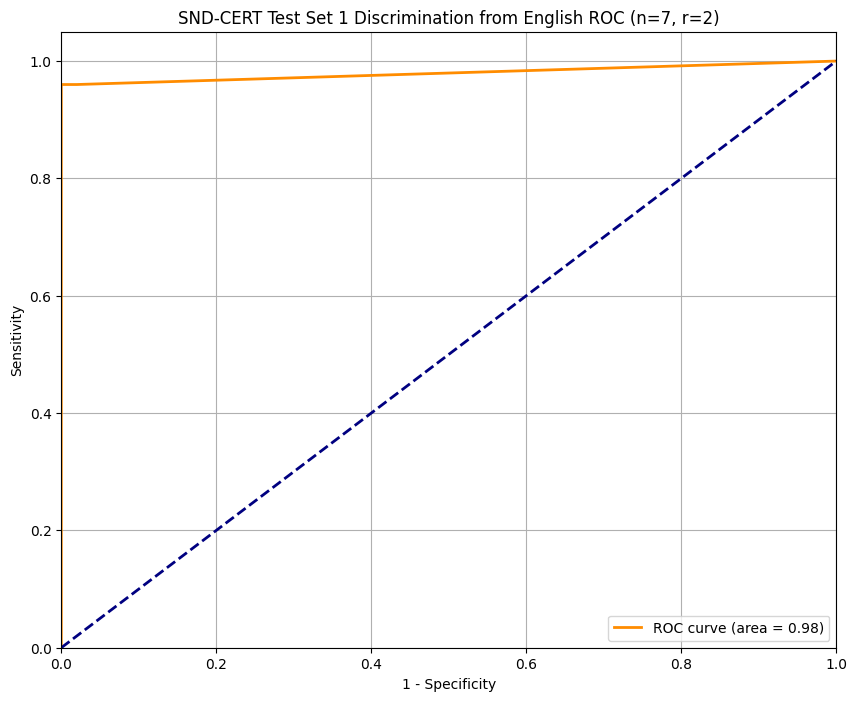

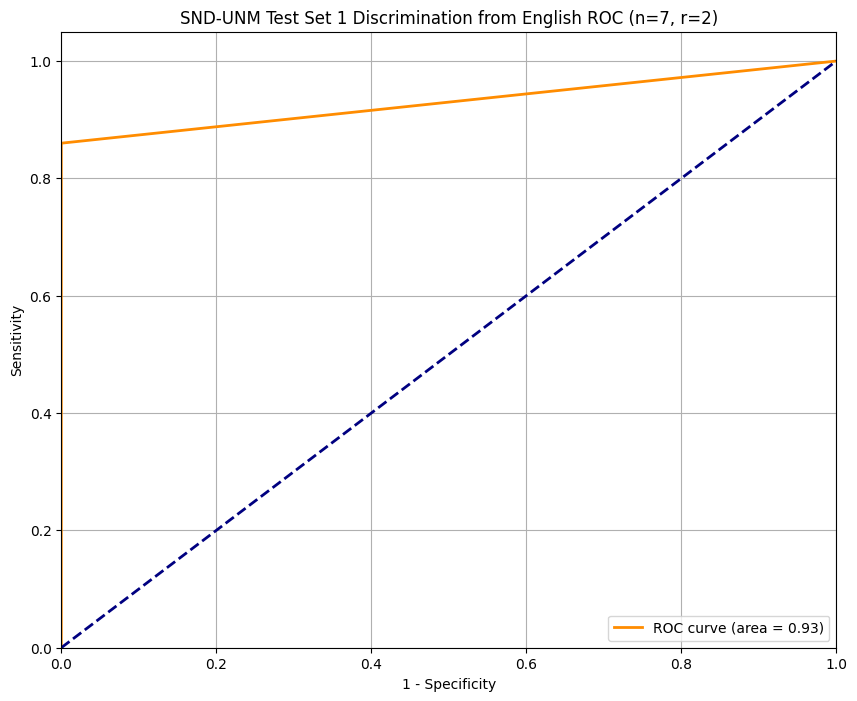

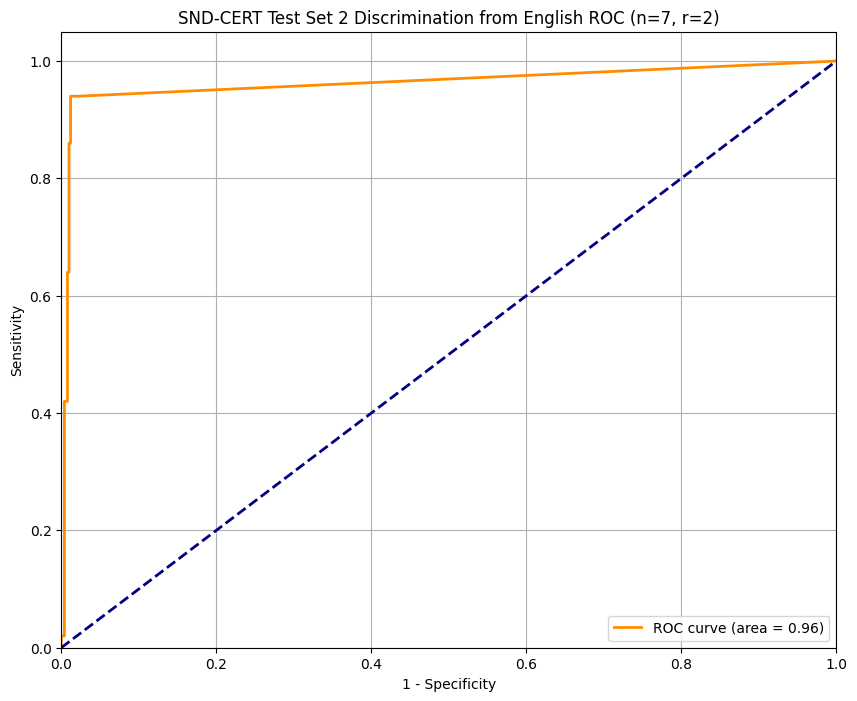

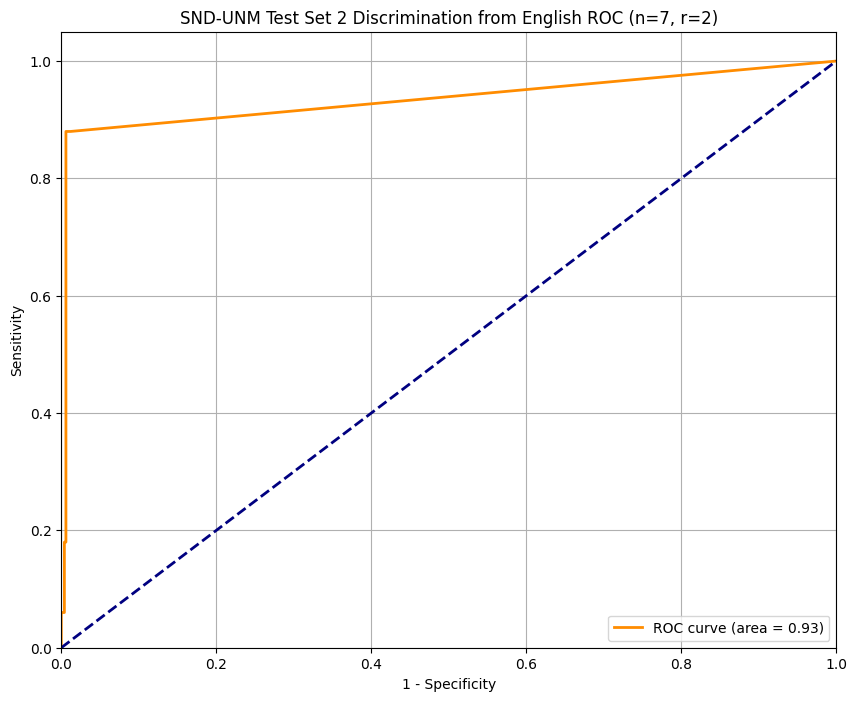

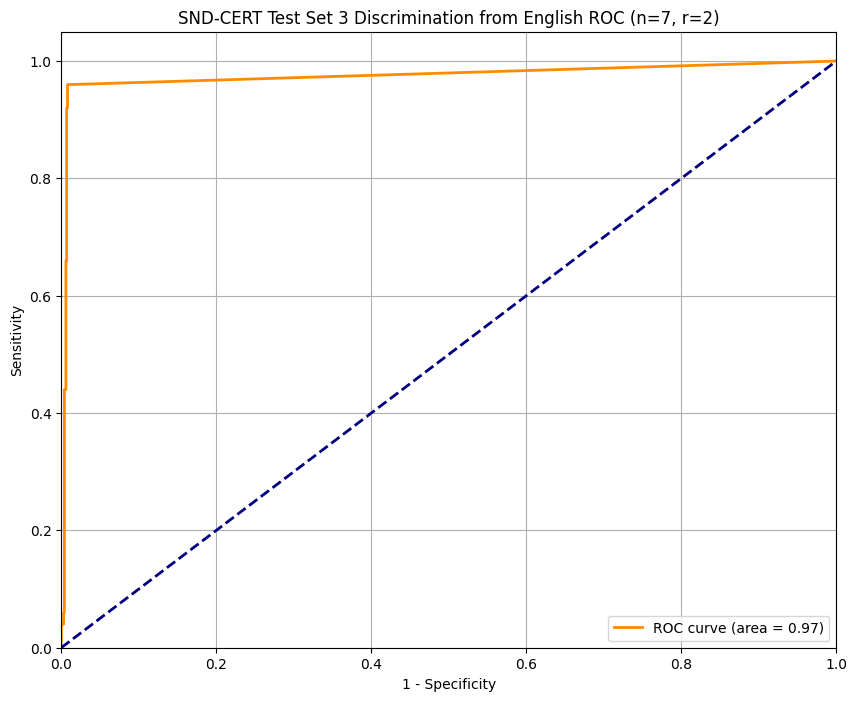

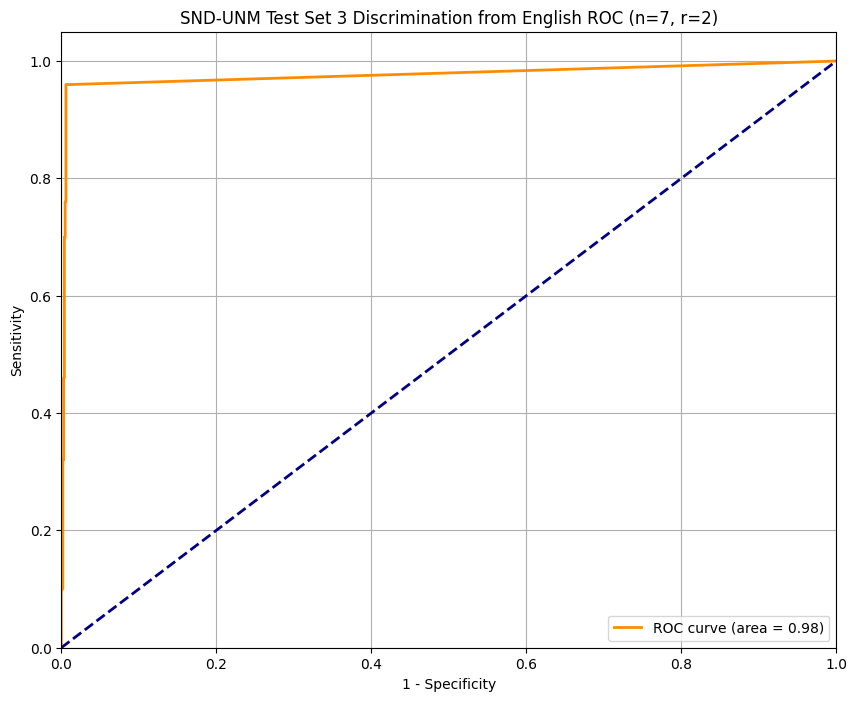

In [126]:
# Plot ROC Curve for SND-CERT and SND-UNM Test Sets for r = 2
plot_roc_curve(fpr_cert1_r2, tpr_cert1_r2, auc_cert1_r2, r=2, language="SND-CERT Test Set 1")
plot_roc_curve(fpr_unm1_r2, tpr_unm1_r2, auc_unm1_r2, r=2, language="SND-UNM Test Set 1")

plot_roc_curve(fpr_cert2_r2, tpr_cert2_r2, auc_cert2_r2, r=2, language="SND-CERT Test Set 2")
plot_roc_curve(fpr_unm2_r2, tpr_unm2_r2, auc_unm2_r2, r=2, language="SND-UNM Test Set 2")

plot_roc_curve(fpr_cert3_r2, tpr_cert3_r2, auc_cert3_r2, r=2, language="SND-CERT Test Set 3")
plot_roc_curve(fpr_unm3_r2, tpr_unm3_r2, auc_unm3_r2, r=2, language="SND-UNM Test Set 3")

In [128]:
# Load the scores and labels for the first test set of the snd-cert dataset for r = 3
scores_cert1_r3, labels_cert1_r3 = get_sequences_score(
    "syscalls/snd-cert/scores/snd_cert_test_set_1_chunks_scores_r3.txt",
    "syscalls/snd-cert/tests/snd_cert_test_set_1_identifiers.txt",
    "syscalls/snd-cert/labels/snd-cert.1.labels")

# Load the scores and labels for the first test set of the snd-unm dataset for r = 3
scores_unm1_r3, labels_unm1_r3 = get_sequences_score("syscalls/snd-unm/scores/snd_unm_test_set_1_chunks_scores_r3.txt",
                                                     "syscalls/snd-unm/tests/snd_unm_test_set_1_identifiers.txt",
                                                     "syscalls/snd-unm/labels/snd-unm.1.labels")

# Load the scores and labels for the second test set of the snd-cert dataset for r = 3
scores_cert2_r3, labels_cert2_r3 = get_sequences_score(
    "syscalls/snd-cert/scores/snd_cert_test_set_2_chunks_scores_r3.txt",
    "syscalls/snd-cert/tests/snd_cert_test_set_2_identifiers.txt",
    "syscalls/snd-cert/labels/snd-cert.2.labels")

# Load the scores and labels for the second test set of the snd-unm dataset for r = 3 
scores_unm2_r3, labels_unm2_r3 = get_sequences_score("syscalls/snd-unm/scores/snd_unm_test_set_2_chunks_scores_r3.txt",
                                                     "syscalls/snd-unm/tests/snd_unm_test_set_2_identifiers.txt",
                                                     "syscalls/snd-unm/labels/snd-unm.2.labels")

# Load the scores and labels for the third test set of the snd-cert dataset for r = 3
scores_cert3_r3, labels_cert3_r3 = get_sequences_score(
    "syscalls/snd-cert/scores/snd_cert_test_set_3_chunks_scores_r3.txt",
    "syscalls/snd-cert/tests/snd_cert_test_set_3_identifiers.txt",
    "syscalls/snd-cert/labels/snd-cert.3.labels")

# Load the scores and labels for the third test set of the snd-unm dataset for r = 3 
scores_unm3_r3, labels_unm3_r3 = get_sequences_score("syscalls/snd-unm/scores/snd_unm_test_set_3_chunks_scores_r3.txt",
                                                     "syscalls/snd-unm/tests/snd_unm_test_set_3_identifiers.txt",
                                                     "syscalls/snd-unm/labels/snd-unm.3.labels")

In [129]:
# Calculate AUC for each test set
fpr_cert1_r3, tpr_cert1_r3, auc_cert1_r3 = compute_auc(scores_cert1_r3, labels_cert1_r3)
fpr_unm1_r3, tpr_unm1_r3, auc_unm1_r3 = compute_auc(scores_unm1_r3, labels_unm1_r3)

fpr_cert2_r3, tpr_cert2_r3, auc_cert2_r3 = compute_auc(scores_cert2_r3, labels_cert2_r3)
fpr_unm2_r3, tpr_unm2_r3, auc_unm2_r3 = compute_auc(scores_unm2_r3, labels_unm2_r3)

fpr_cert3_r3, tpr_cert3_r3, auc_cert3_r3 = compute_auc(scores_cert3_r3, labels_cert3_r3)
fpr_unm3_r3, tpr_unm3_r3, auc_unm3_r3 = compute_auc(scores_unm3_r3, labels_unm3_r3)

# Print AUC scores
print(f"AUC for SND-CERT Test Set 1: {auc_cert1_r3}")
print(f"AUC for SND-UNM Test Set 1: {auc_unm1_r3}\n")

print(f"AUC for SND-CERT Test Set 2: {auc_cert2_r3}")
print(f"AUC for SND-UNM Test Set 2: {auc_unm2_r3}\n")

print(f"AUC for SND-CERT Test Set 3: {auc_cert3_r3}")
print(f"AUC for SND-UNM Test Set 3: {auc_unm3_r3}")

AUC for SND-CERT Test Set 1: 0.9783999999999999
AUC for SND-UNM Test Set 1: 0.97

AUC for SND-CERT Test Set 2: 0.98394
AUC for SND-UNM Test Set 2: 0.95284

AUC for SND-CERT Test Set 3: 0.97514
AUC for SND-UNM Test Set 3: 0.98543


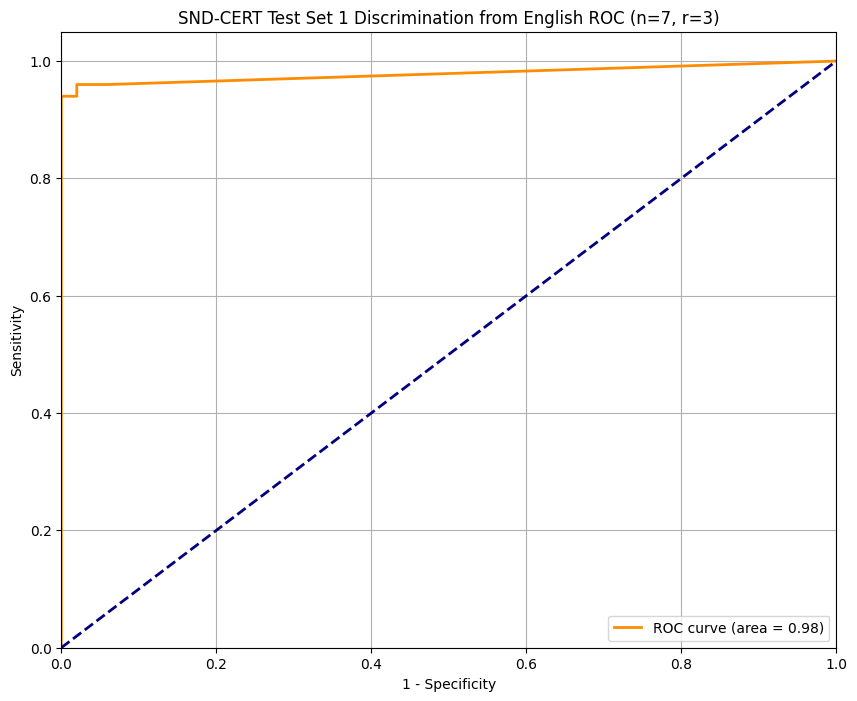

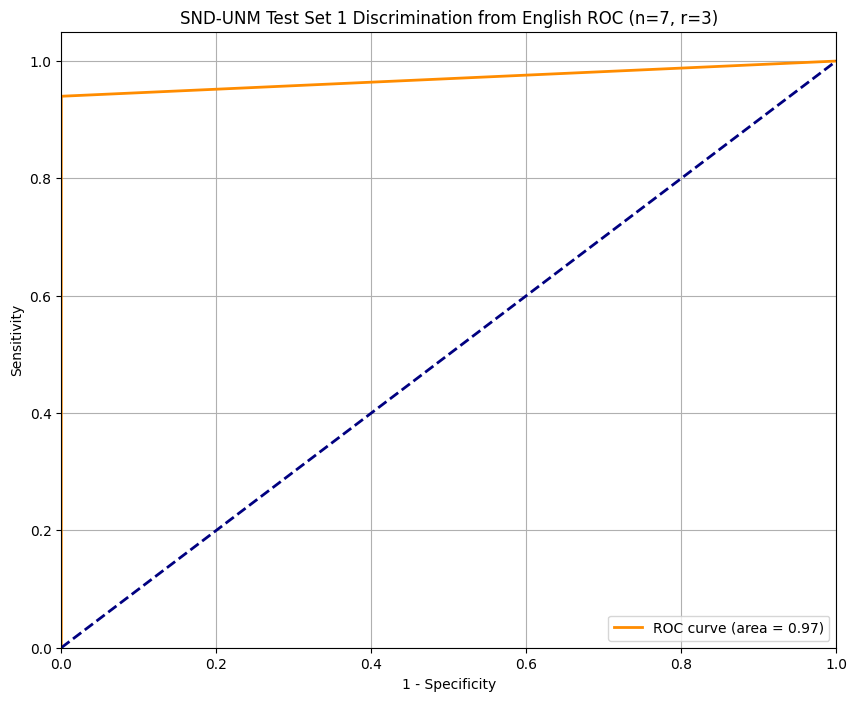

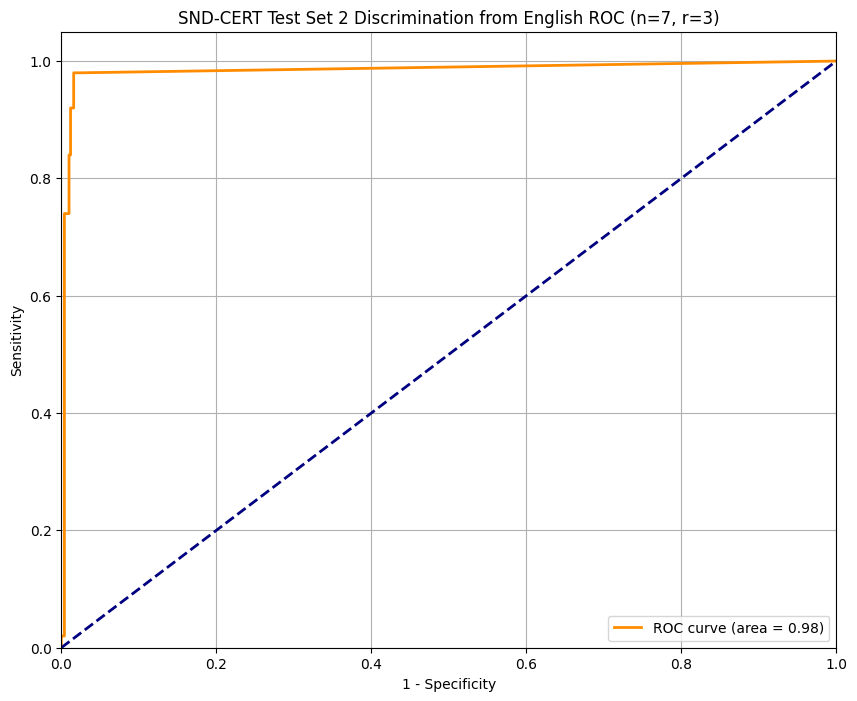

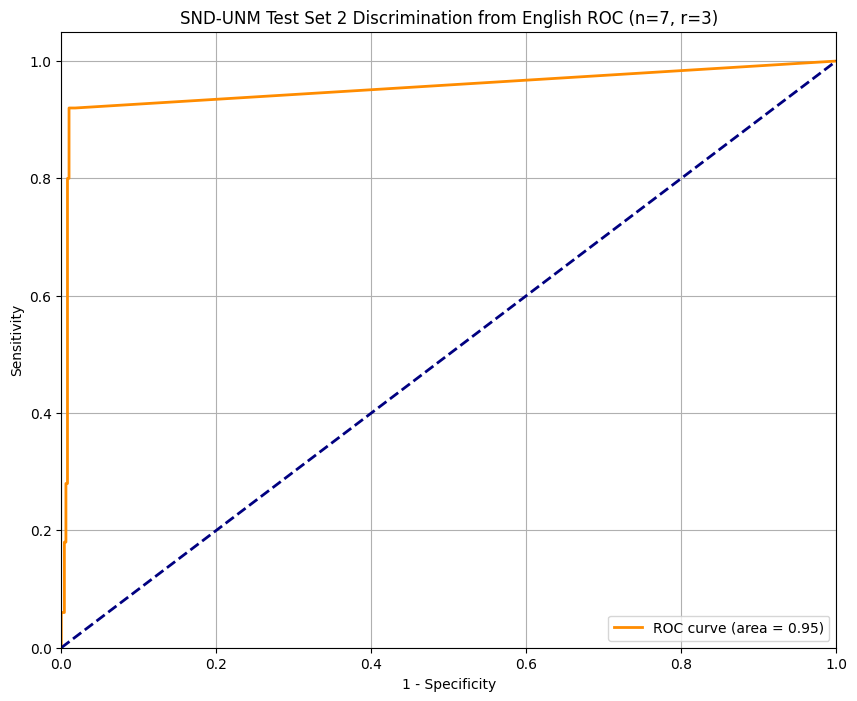

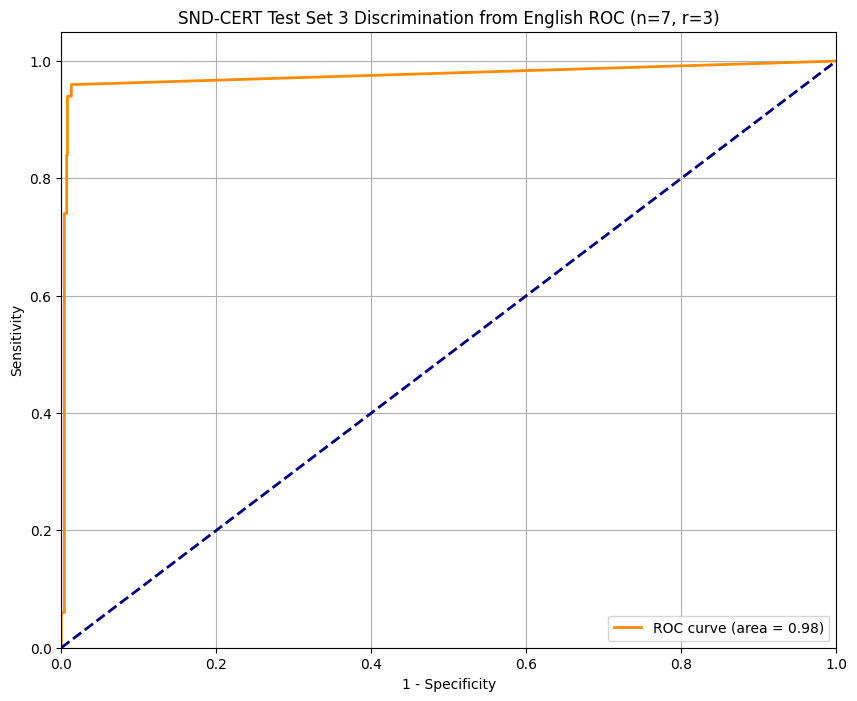

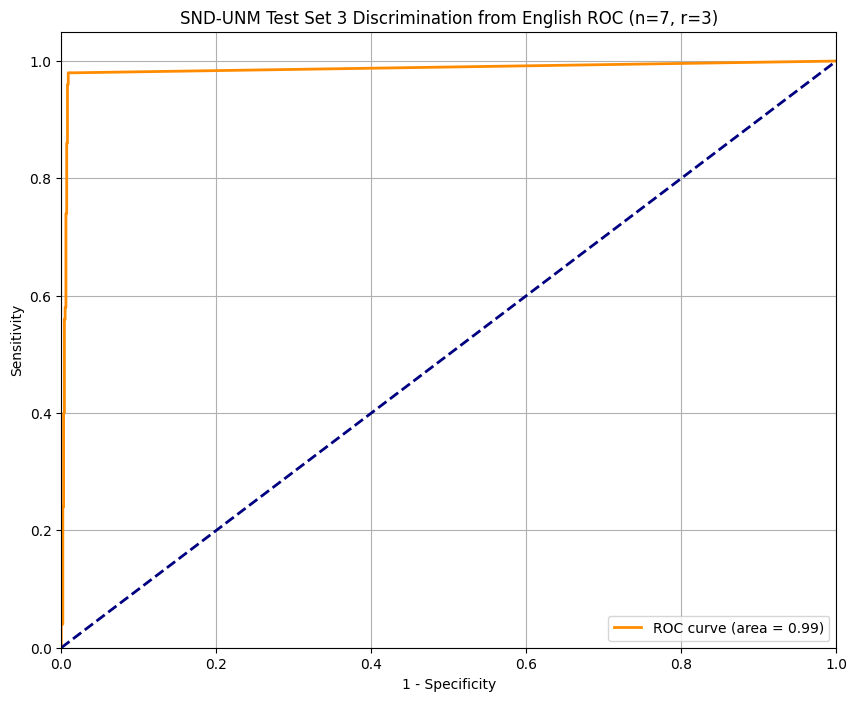

In [130]:
# Plot ROC Curve for SND-CERT and SND-UNM Test Sets for r = 3
plot_roc_curve(fpr_cert1_r3, tpr_cert1_r3, auc_cert1_r3, r=3, language="SND-CERT Test Set 1")
plot_roc_curve(fpr_unm1_r3, tpr_unm1_r3, auc_unm1_r3, r=3, language="SND-UNM Test Set 1")

plot_roc_curve(fpr_cert2_r3, tpr_cert2_r3, auc_cert2_r3, r=3, language="SND-CERT Test Set 2")
plot_roc_curve(fpr_unm2_r3, tpr_unm2_r3, auc_unm2_r3, r=3, language="SND-UNM Test Set 2")

plot_roc_curve(fpr_cert3_r3, tpr_cert3_r3, auc_cert3_r3, r=3, language="SND-CERT Test Set 3")
plot_roc_curve(fpr_unm3_r3, tpr_unm3_r3, auc_unm3_r3, r=3, language="SND-UNM Test Set 3")

In [132]:
# Load the scores and labels for the first test set of the snd-cert dataset for r = 4
scores_cert1_r4, labels_cert1_r4 = get_sequences_score(
    "syscalls/snd-cert/scores/snd_cert_test_set_1_chunks_scores_r4.txt",
    "syscalls/snd-cert/tests/snd_cert_test_set_1_identifiers.txt",
    "syscalls/snd-cert/labels/snd-cert.1.labels")

# Load the scores and labels for the first test set of the snd-unm dataset for r = 4
scores_unm1_r4, labels_unm1_r4 = get_sequences_score("syscalls/snd-unm/scores/snd_unm_test_set_1_chunks_scores_r4.txt",
                                                     "syscalls/snd-unm/tests/snd_unm_test_set_1_identifiers.txt",
                                                     "syscalls/snd-unm/labels/snd-unm.1.labels")

# Load the scores and labels for the second test set of the snd-cert dataset for r = 4
scores_cert2_r4, labels_cert2_r4 = get_sequences_score(
    "syscalls/snd-cert/scores/snd_cert_test_set_2_chunks_scores_r4.txt",
    "syscalls/snd-cert/tests/snd_cert_test_set_2_identifiers.txt",
    "syscalls/snd-cert/labels/snd-cert.2.labels")

# Load the scores and labels for the second test set of the snd-unm dataset for r = 4 
scores_unm2_r4, labels_unm2_r4 = get_sequences_score("syscalls/snd-unm/scores/snd_unm_test_set_2_chunks_scores_r4.txt",
                                                     "syscalls/snd-unm/tests/snd_unm_test_set_2_identifiers.txt",
                                                     "syscalls/snd-unm/labels/snd-unm.2.labels")

# Load the scores and labels for the third test set of the snd-cert dataset for r = 4
scores_cert3_r4, labels_cert3_r4 = get_sequences_score(
    "syscalls/snd-cert/scores/snd_cert_test_set_3_chunks_scores_r4.txt",
    "syscalls/snd-cert/tests/snd_cert_test_set_3_identifiers.txt",
    "syscalls/snd-cert/labels/snd-cert.3.labels")

# Load the scores and labels for the third test set of the snd-unm dataset for r = 4 
scores_unm3_r4, labels_unm3_r4 = get_sequences_score("syscalls/snd-unm/scores/snd_unm_test_set_3_chunks_scores_r4.txt",
                                                     "syscalls/snd-unm/tests/snd_unm_test_set_3_identifiers.txt",
                                                     "syscalls/snd-unm/labels/snd-unm.3.labels")

In [133]:
# Calculate AUC for each test set
fpr_cert1_r4, tpr_cert1_r4, auc_cert1_r4 = compute_auc(scores_cert1_r4, labels_cert1_r4)
fpr_unm1_r4, tpr_unm1_r4, auc_unm1_r4 = compute_auc(scores_unm1_r4, labels_unm1_r4)

fpr_cert2_r4, tpr_cert2_r4, auc_cert2_r4 = compute_auc(scores_cert2_r4, labels_cert2_r4)
fpr_unm2_r4, tpr_unm2_r4, auc_unm2_r4 = compute_auc(scores_unm2_r4, labels_unm2_r4)

fpr_cert3_r4, tpr_cert3_r4, auc_cert3_r4 = compute_auc(scores_cert3_r4, labels_cert3_r4)
fpr_unm3_r4, tpr_unm3_r4, auc_unm3_r4 = compute_auc(scores_unm3_r4, labels_unm3_r4)

# Print AUC scores
print(f"AUC for SND-CERT Test Set 1: {auc_cert1_r4}")
print(f"AUC for SND-UNM Test Set 1: {auc_unm1_r4}\n")

print(f"AUC for SND-CERT Test Set 2: {auc_cert2_r4}")
print(f"AUC for SND-UNM Test Set 2: {auc_unm2_r4}\n")

print(f"AUC for SND-CERT Test Set 3: {auc_cert3_r4}")
print(f"AUC for SND-UNM Test Set 3: {auc_unm3_r4}")

AUC for SND-CERT Test Set 1: 0.9779999999999999
AUC for SND-UNM Test Set 1: 0.97

AUC for SND-CERT Test Set 2: 0.98418
AUC for SND-UNM Test Set 2: 0.96298

AUC for SND-CERT Test Set 3: 0.97506
AUC for SND-UNM Test Set 3: 0.98533


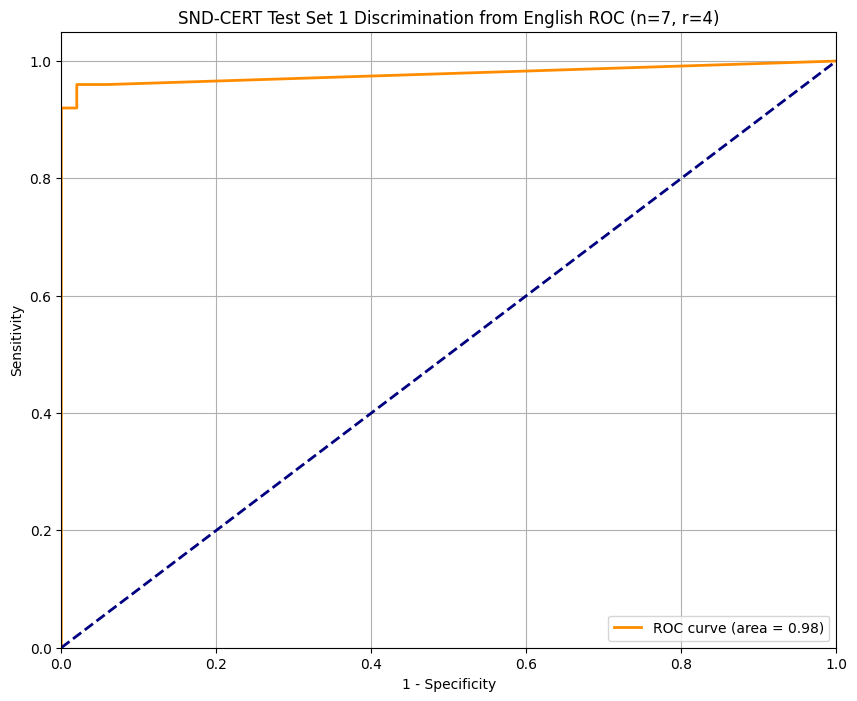

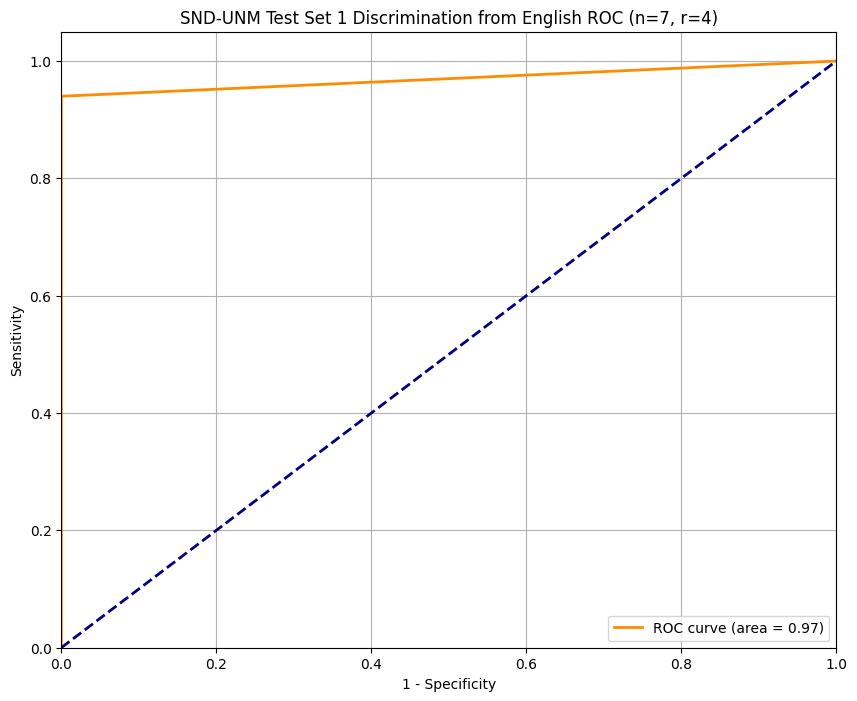

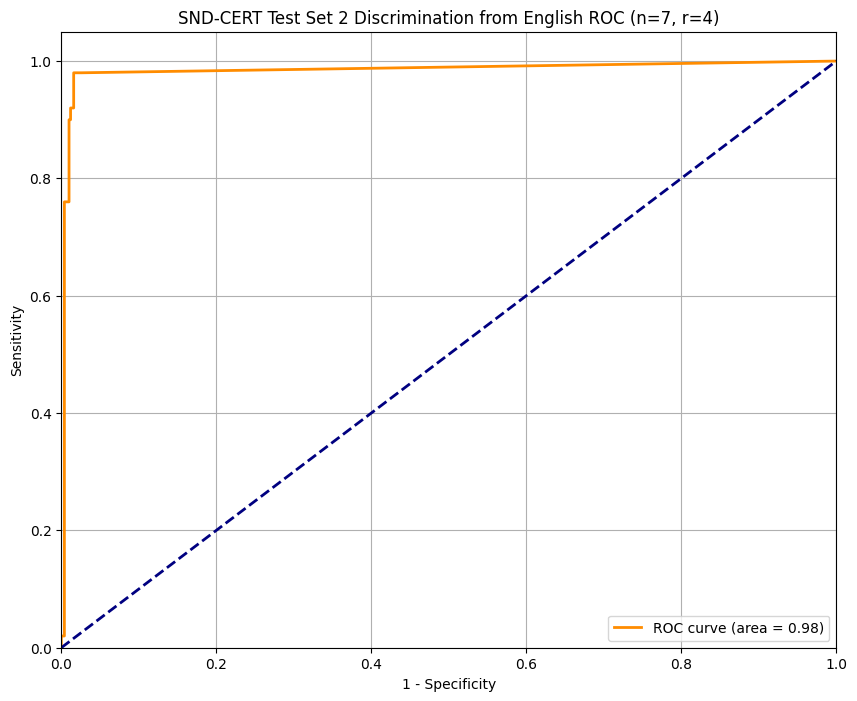

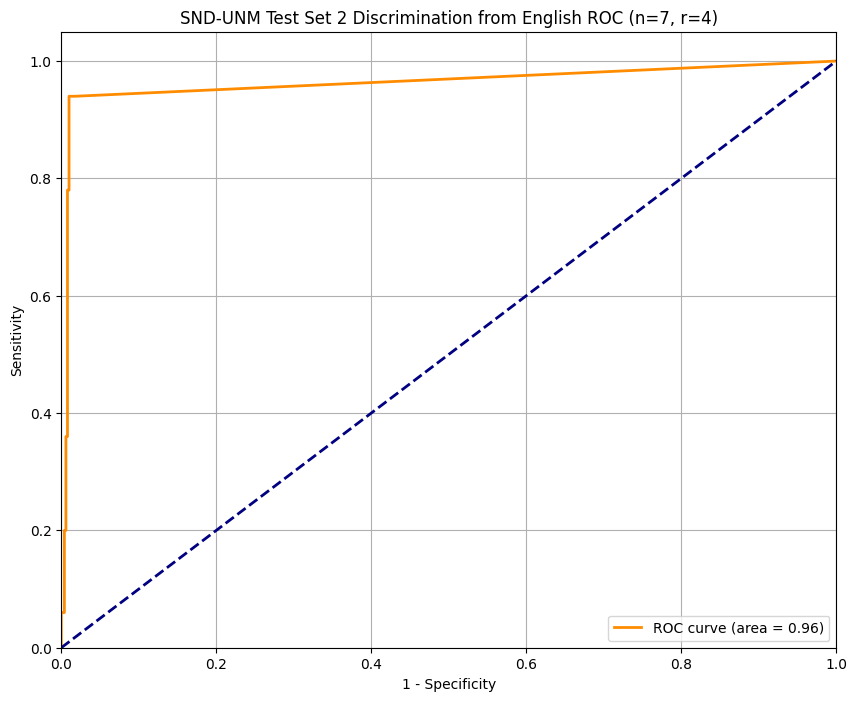

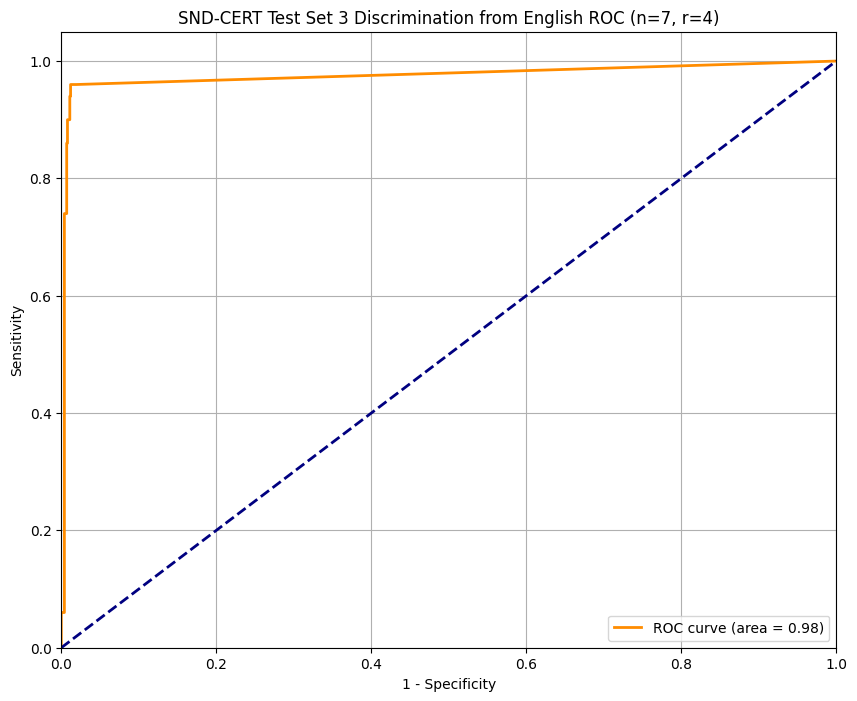

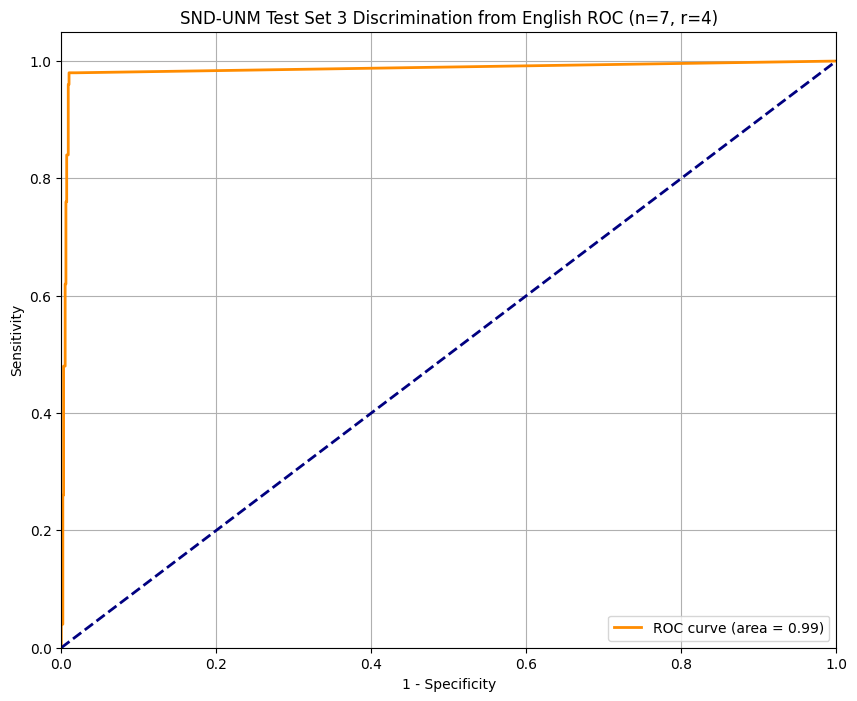

In [134]:
# Plot ROC Curve for SND-CERT and SND-UNM Test Sets for r = 4
plot_roc_curve(fpr_cert1_r4, tpr_cert1_r4, auc_cert1_r4, r=4, language="SND-CERT Test Set 1")
plot_roc_curve(fpr_unm1_r4, tpr_unm1_r4, auc_unm1_r4, r=4, language="SND-UNM Test Set 1")

plot_roc_curve(fpr_cert2_r4, tpr_cert2_r4, auc_cert2_r4, r=4, language="SND-CERT Test Set 2")
plot_roc_curve(fpr_unm2_r4, tpr_unm2_r4, auc_unm2_r4, r=4, language="SND-UNM Test Set 2")

plot_roc_curve(fpr_cert3_r4, tpr_cert3_r4, auc_cert3_r4, r=4, language="SND-CERT Test Set 3")
plot_roc_curve(fpr_unm3_r4, tpr_unm3_r4, auc_unm3_r4, r=4, language="SND-UNM Test Set 3")